# Task #2

A template code for training an RBM on Rydberg atom data (the full dataset) is provided below. For the first part of this task (determining the minimum number of hidden units), start with 20 hidden units. 

Imports and loadining in data:

In [1]:
import numpy as np
import torch
from RBM_helper import RBM
from tqdm import tqdm
import matplotlib.pyplot as plt
import Rydberg_energy_calculator

training_data = torch.from_numpy(np.loadtxt("Rydberg_data.txt"))

Define the RBM:

In [2]:
def train_rbm(training_data,epochs,num_samples,n_vis,n_hin,N_draws=1000):
    '''
        Train a restricted Boltzmann Machine 
        
        Args:
            training_data: 
            epochs:
            num_samples:
            N_draws:
        Returns:
            Array: An N_draw array containing the energies  
    '''
    
    # Instantiate the RBM
    rbm = RBM(n_vis, n_hin)
    
    # Carry out the training over the defined number of epochs
    for e in range(1, epochs+1):
        # do one epoch of training
        rbm.train(training_data)   

    E_samples = np.zeros(N_draws)
    
    for k in tqdm(range(0,N_draws)):
        init_state = torch.zeros(num_samples, n_vis)
        RBM_samples = rbm.draw_samples(100, init_state)
        energies = Rydberg_energy_calculator.energy(RBM_samples, rbm.wavefunction)
        E_samples[k] = energies.item()
    
    
    return E_samples

def confidence_interval(x):
    '''
    
        Compute the 68% and 96% confidence inteval of a data set
        
        Args:
            x: numpy array
        Returns:
            Tuple: array1,array2
            
            where array1 and array2 are each numpy arrays of length=3
            array1 = [lower_68%_bound, median , upper_68%_bound]
            array2 = [lower_96%_bound, median , upper_96%_bound]
    '''
    x_68 = np.percentile(x, [16,50,84])
    x_96 = np.percentile(x, [2,50,98])
    
    return x_68,x_96

In [20]:
print(training_data.shape[0])

20000


Train the RBM:

In [27]:
epochs = 1000
num_samples = training_data.shape[0]
exact_energy = -4.1203519096
tol = 1e-4 # The desired tolerance level
n_hid_max=10
N_draws =50 # The number of samples to draw at the end for statistics 

n_hidden_array = []
E_68_nhidden = []
E_96_nhidden = []

for nk in range(1,20,5):
    n_hidden_array.append(nk)
    n_training_data = training_data.shape[1]
    n_hin = nk
    E_samples = train_rbm(training_data,epochs,n_vis=n_training_data,n_hin=n_hin,num_samples=num_samples,N_draws=N_draws)
    E_68,E_96 = confidence_interval(E_samples)
    E_68_nhidden.append(E_68)
    E_96_nhidden.append(E_96)
    print(nk,E_68[1],exact_energy, abs(E_68[1]-exact_energy))

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


1 -4.120016989338227 -4.1203519096 0.000334920261773064


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


16 -4.120050902517135 -4.1203519096 0.00030100708286529


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]

31 -4.1198641713246955 -4.1203519096 0.00048773827530457226


In [30]:
# Preprocess the results in order to generate the plot

E_96_nhidden = np.array(E_96_nhidden)
E_68_nhidden = np.array(E_68_nhidden)

delta_E_med =  abs(E_96_nhidden[:,1]-exact_energy) #/tol
delta_E_lower_68 =  abs(E_68_nhidden[:,0]-exact_energy)#/tol
delta_E_upper_68 =  abs(E_68_nhidden[:,2]-exact_energy)#/tol
delta_E_lower_96 =  abs(E_96_nhidden[:,0]-exact_energy)#/tol
delta_E_upper_96 =  abs(E_96_nhidden[:,2]-exact_energy)#/tol

# Determine the number of hidden nodes required for uncertainty band to overlap tolerance level
n_hidden_tol_indx = np.argmin(delta_E_med)
n_hidden_tol = n_hidden_array[n_hidden_tol_indx]


print('='*100)
print('The minimum number of hidden units to reach tolerance level is: ',n_hidden_tol)
print('='*100)

[False False False]
The minimum number of hidden units to reach tolerance level is:  16


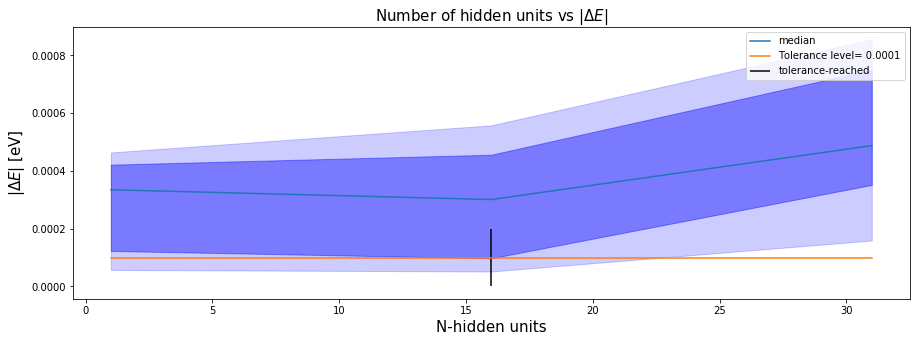

In [31]:
plt.figure(figsize=(15,5))
plt.title(r'Number of hidden units vs $|\Delta E |$',size=15)
plt.plot(n_hidden_array,delta_E_med,label='median')
plt.fill_between(n_hidden_array,delta_E_lower_68, delta_E_upper_68,color='blue',alpha='0.4',edgecolor='b')
plt.fill_between(n_hidden_array,delta_E_lower_96, delta_E_upper_96,color='blue',alpha='0.2',edgecolor='b')
plt.plot(n_hidden_array,tol*np.ones(len(n_hidden_array)),label='Tolerance level= '+str(tol))
plt.vlines( n_hidden_array[n_hidden_tol_indx],ymin=0,ymax=tol*2,label='tolerance-reached')
plt.xlabel('N-hidden units',size=15)
plt.ylabel(r'$|\Delta E|$ [eV]',size=15)
plt.legend()
plt.show()

In [6]:
epochs = 10
num_samples = training_data.shape[0]
exact_energy = -4.1203519096
tol = 1e-4 # The desired tolerance level
n_hid_max=10
N_draws =100 # The number of samples to draw at the end 

n_samples_array = []
E_68_nsamples = []
E_96_nsamples = []

for nk in range(500,training_data.shape[0],5000):
    n_samples_array.append(nk)
    n_training_data = training_data.shape[1]
    n_hin = n_hidden_tol # The optimal number of hidden layers
    E_samples = train_rbm(training_data,epochs,n_vis=n_training_data,n_hin=n_hin,num_samples=nk,N_draws=N_draws)
    E_68,E_96 = confidence_interval(E_samples)
    E_68_nsamples.append(E_68)
    E_96_nsamples.append(E_96)

100%|██████████| 100/100 [07:00<00:00,  4.04s/it]


In [7]:
E_96_nsamples = np.array(E_96_nsamples)
E_68_nsamples= np.array(E_68_nsamples)

ddelta_E_med =  abs(E_96_nsamples[:,1]-exact_energy)
ddelta_E_lower_68 =  abs(E_68_nsamples[:,0]-exact_energy)
ddelta_E_upper_68 =  abs(E_68_nsamples[:,2]-exact_energy)
ddelta_E_lower_96 =  abs(E_96_nsamples[:,0]-exact_energy)
ddelta_E_upper_96 =  abs(E_96_nsamples[:,2]-exact_energy)

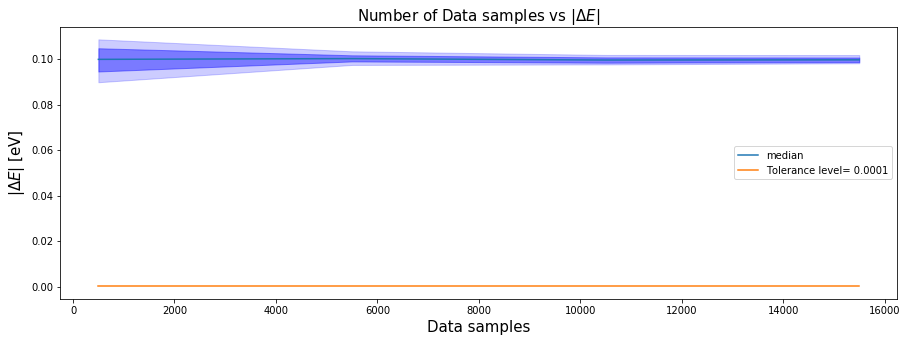

In [8]:
plt.figure(figsize=(15,5))
plt.title(r'Number of Data samples vs $|\Delta E |$',size=15)
plt.plot(n_samples_array,ddelta_E_med,label='median')
plt.fill_between(n_samples_array,ddelta_E_lower_68, ddelta_E_upper_68,color='blue',alpha='0.4',edgecolor='b')
plt.fill_between(n_samples_array,ddelta_E_lower_96, ddelta_E_upper_96,color='blue',alpha='0.2',edgecolor='b')
plt.plot(n_samples_array,tol*np.ones(len(n_samples_array)),label='Tolerance level= '+str(tol))
plt.xlabel('Data samples',size=15)
plt.ylabel(r'$|\Delta E|$ [eV]',size=15)
plt.legend()
plt.show()
